## Predicting the Minority Percentage for Public High Schools
**This notebook explores predicting the Minority Percentage for public high schools in North Carolina.** 
* Using **NO** racial composition data, can we predict the minority percentage for a public high school?
* The North Carolina Educational Attainment Data Repository for Machine Learning is located on Github at: https://github.com/jakemdrew/EducationDataNC 
* The dataset used in this notebook is created prepared for machine learning in the notebook: 
  NC EA Public High Schools Dataset Expaneded Feb 2018
* The dataset name used in this notbook is: 
  HighSchoolsML_02_2018_Expanded.csv

**For documentation on various Generalized Linear Models in Sklearn see:**
* http://scikit-learn.org/stable/modules/linear_model.html
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python

In [23]:
#import required Libraries
import pandas as pd
import numpy as np

#Read in the high schools dataset - NC EA Public High Schools Dataset Feb 2018
url="https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/Machine%20Learning%20Datasets/HighSchoolsML_02_2018_Expanded.csv"
schData=pd.read_csv(url, low_memory=False)

#inspect data 
schData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Columns: 140 entries, title1_type_flg to 1_to_1_access_Yes
dtypes: bool(6), float64(114), int64(20)
memory usage: 463.3 KB


In [24]:
#Delete all racial composition data from our dataset. 
raceCompositionFields = ['Indian Male','Asian Male','Hispanic Male','Black Male','White Male'
                         ,'Pacific Island Male','Pacific Island Female','Two or  More Male','Two or  More Female'
                         ,'Pacific Island','Majority_Minority','White_Pct','Two or More']


# create x explanatory and y response variables for regression
Y_MinorityPct = (1 - schData['White_Pct']) * 100
Y = Y_MinorityPct

#Delete all racial composition data from our dataset.
X_highSchools = schData.drop(raceCompositionFields, axis=1)

#inspect data 
X_highSchools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Columns: 128 entries, title1_type_flg to 1_to_1_access_Yes
dtypes: bool(6), float64(102), int64(20)
memory usage: 422.0 KB


In [3]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
#from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
#scaler = StandardScaler()
#scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
#X_highSchools = scaler.transform(X_highSchools)

## Cross Validation
**Cross validation is performed using repeated holdout using ShuffleSplit()**
* Ten folds are used
* The split is: 90% training data and 10% test data
* A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [25]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

## Custom Scorers for Evaluating Regression Models 

**All regression models created in this notebook are validated using the following metrics:**
* Mean Absolute Error (MAE)
* Root Mean Squared Error (RMSE) - https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
* Mean Absolute Percentage Error (MAPE) - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python

**For details on making scorers to return multiple mean error scores see:**
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
* https://github.com/scikit-learn/scikit-learn/pull/7388
* https://github.com/drorata/multiscorer

In [4]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual <> 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               } 

## Regression Model Evaluation
** All regression models are evaluated using the regression model evaluation function below: ** 
* The following regression evaluation function uses the cross validation object and the custom scorers in the two cells above in combination with sklearn.model_selection's cross_validate function to perform cross validation for regression estimators.
* The cross validation object above uses a random seed to ensure that all regression estimators are tested on the same randomly selected records for each cross validation fold.
* Custom scorers are created using the three chosen mean error scores and passed into cross_validate(), so all three scores are calcualted using a single call to cross_validate().
* All of this functionality is wrapped within the custom EvaluateRegressionEstimator() function below so multiple regression models may be tested using the same test / train cv data and evaluation scores producing a consistent output for each model without the need to re-write the same code over and over. 

In [5]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults


## Minority Percent - Baseline Regression Model

**Linear Regression is used to create a baseline model.  Since linear regression may predict response variable values outside the range of the training data's response variable, we create a linear regression estimator with minority percentage predictions clipped 0% and 100%. For details see:**
* http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator 
* https://github.com/scikit-learn/scikit-learn/issues/6950
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/template.py
* https://stackoverflow.com/questions/44234682/how-to-use-sklearn-when-target-variable-is-a-proportion

In [7]:
#Make new estimator compatible for use with GridSearchCV() and cross_validate()
# -  Cap predict function for LinearRegression between 0 and 100
# -  See: Roll your own estimator links above for details. 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class CappedLinearRegression(LinearRegression):

    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), 0, 100) 

### Linear Regression Grid Search
** Here we perform a grid search testing 40 models to find the best parameters for our Linear Regression model based on Mean Absolute Error.  See more on parameter tuning with grid search here:**
* http://scikit-learn.org/stable/modules/grid_search.html

In [8]:
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = CappedLinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.5s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=1,
            normalize=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'normalize': (True, False), 'fit_intercept': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [9]:
#Print the parameterization of the best estimator
regGridSearch.best_estimator_

CappedLinearRegression(copy_X=True, fit_intercept=False, n_jobs=1,
            normalize=True)

## Minority Percent - Baseline Regression Model - Cross Validation
**Perform tenfold cross validation using the grid search "best" parameters and our Capped Linear Regression estimator**
* 10-fold cross-validation using the parameters for the top performing model 
* CAP predictions between 0 and 100% 
* Evaluate cross-validation results using MAE, MAPE, and RMSE

In [10]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)


The average MAE for all cv folds is: 			 11.358
The average MAE percentage (MAPE) for all cv folds is: 	 38.562
The average RMSE for all cv folds is: 			 15.006
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,11.885743,50.417181,14.750076
1,9.275029,33.083581,12.038891
2,13.174862,57.447433,17.398358
3,11.051718,32.438133,14.982843
4,12.369730,49.420369,16.559380
5,10.323579,41.534601,13.313878
6,11.849764,35.095527,15.655968
7,10.889197,32.565098,15.211247
8,10.980037,27.467477,14.374024
9,11.785206,26.147032,15.777512


## Minority Percent - Support Vector Regression
**This model uses Support Vector Machines for regression of continuous variables (SVR). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
* http://scikit-learn.org/stable/modules/svm.html

In [11]:
#Create a Linear regression object and perform a grid search to find the best parameters
from sklearn.svm import SVR
reg = SVR()

#Set up SVR parameters to test (WARNING: Creates 320 models!!!) 
costs = [0.001, 0.1, 1, 10]
defGamma = 1 / X_highSchools.shape[1]  #This is the default value for the gamma parameter
kernels = ['linear']
parameters = {'C': costs, 'kernel': kernels}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed: 36.6min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'kernel': ['linear'], 'C': [0.001, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [12]:
#Display the best estimator parameters
regGridSearch.best_estimator_

SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [13]:
from sklearn.svm import SVR

#Create a regression estimator with best parameters for cross validation
regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                   kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 12.269
The average MAE percentage (MAPE) for all cv folds is: 	 45.533
The average RMSE for all cv folds is: 			 15.764
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,13.238264,63.381244,18.289994
1,10.600348,36.384931,13.158511
2,12.685616,62.304307,16.373286
3,11.228228,44.744180,14.072627
4,14.617232,51.721499,17.441750
5,11.862349,53.538111,15.837460
6,13.663913,44.327459,19.146214
7,11.729683,34.344859,14.807543
8,10.798493,32.923485,13.032286
9,12.265660,31.657140,15.475955


In [14]:
#Do we minority rates greater than 100%?
regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                   kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 120.96669953639147)


## Minority Percent - Lasso Regression
**This model uses Lasso regression (L1 Norm). Please see documentation here:"**
* **Caution!** - See documentation for fit_intercept, normalize, and copy_X. Lasso can over-write your X data!
* Lasso may also perform scaling as well.  Please see docs!
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [15]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso

reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 185 out of 200 | elapsed:    6.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    6.4s finished


Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'warm_start': [True, False], 'alpha': [0.001, 0.1, 1, 10, 20], 'selection': ['cyclic', 'random']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [16]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='random', tol=0.0001, warm_start=True)

In [17]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 11.379
The average MAE percentage (MAPE) for all cv folds is: 	 38.538
The average RMSE for all cv folds is: 			 15.378
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,12.649749,53.733604,16.005761
1,9.170610,33.110725,11.924783
2,13.878514,58.035955,20.067636
3,11.135131,32.542778,15.367150
4,12.152119,47.982081,16.223440
5,10.166617,40.200999,13.285337
6,11.919248,36.302187,15.581265
7,10.528372,31.205181,14.674864
8,10.025288,25.805534,12.812507
9,12.165260,26.461377,17.838612


In [18]:
#Do we predict minority percentages greater than 100%?
regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=True)

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 118.54669736885506)


## Minority Percent - Ridge Regression
**This model uses Ridge regression (L2 Norm). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [19]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

reg = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=1000, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parameters = {'alpha': alpha, 'solver': solver}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done 295 tasks      | elapsed:   11.2s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:   11.5s finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='auto', tol=0.0001),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20], 'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [20]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='sparse_cg', tol=0.0001)

In [21]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 10.545
The average MAE percentage (MAPE) for all cv folds is: 	 38.564
The average RMSE for all cv folds is: 			 13.447
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,11.848422,54.508729,14.300558
1,9.589175,35.841501,12.222114
2,11.057961,49.703051,14.242104
3,9.315719,33.598482,12.105574
4,12.099320,50.267307,15.586012
5,9.688917,42.194234,12.987417
6,11.203126,35.965721,14.624100
7,9.327932,27.593089,11.610627
8,9.929186,27.862739,12.439098
9,11.392308,28.109425,14.348724


In [22]:
#Do we predict minority percentages greater than 100%?
regEstimator = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=0, solver='saga', tol=0.0001)

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 119.18397998085163)


## Minority Percent - Elastic Net Regression
**This model uses Elastic Net Regression (L1 and L2 Norm mixing). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [23]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import ElasticNet

reg = ElasticNet(fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)
 
#Test parameters
l1_ratio = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
alpha = [0.001, 0.1, 1, 10]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'l1_ratio': l1_ratio, 'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done 545 tasks      | elapsed:    8.2s
[Parallel(n_jobs=8)]: Done 945 out of 960 | elapsed:    9.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 960 out of 960 | elapsed:    9.9s finished


Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'warm_start': [True, False], 'l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.75, 1], 'selection': ['cyclic', 'random'], 'alpha': [0.001, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [24]:
#Display the best estimator parameters
regGridSearch.best_estimator_

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.75,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='random', tol=0.0001, warm_start=True)

In [25]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 10.491
The average MAE percentage (MAPE) for all cv folds is: 	 38.477
The average RMSE for all cv folds is: 			 13.374
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,11.832307,54.410338,14.247416
1,9.591794,35.894065,12.214562
2,10.935609,49.315636,14.074785
3,9.195276,33.536027,11.973262
4,12.076672,50.168907,15.505404
5,9.652278,42.249169,12.973201
6,11.143050,35.875125,14.533208
7,9.262460,27.349950,11.532120
8,9.874082,27.874297,12.414649
9,11.347054,28.093689,14.275123


In [26]:
#Do we predict minority percentages greater than 100%?
regEstimator = ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.75,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=True)

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 119.4040945935933)


## Minority Percent - Logit Regression using Python 
**This model uses a custom Logit model based on transformations of the Linear Regression object. Please see documentation here:"**
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python
* https://stackoverflow.com/questions/44234682/how-to-use-sklearn-when-target-variable-is-a-proportion

In [27]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class LogitRegression(LinearRegression):

    def fit(self, x, p):
        p[p==0] = 0.009    #0.1111111111111111 
        p[p==1] = 0.991    #0.9999999999999999  big precision seems to kill MAE scores here?
        #e = 0.0000000000000001
        #p = p * e + 0.5 * e                    This technique was really bad too. 
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        return super(LogitRegression, self).fit(x, y)

    def predict(self, x):
        y = super(LogitRegression, self).predict(x)
        yhat = 1 / (np.exp(-y) + 1)
        yhat[yhat <= 0.009] = 0
        yhat[yhat >= 0.991] = 1
        return yhat

In [28]:
#convert y to a proability 
Y = Y_MinorityPct / 100

#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = LogitRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   #, n_jobs=8 # jobs to run in parallel (This breaks the custom estimators for some reason!)
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

C:\Users\Jake\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: overflow encountered in exp
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.6s finished


Fitting 10 folds for each of 4 candidates, totalling 40 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LogitRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'normalize': (True, False), 'fit_intercept': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [29]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogitRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)

**Since we converted our response variable to a percentile MAE and RMSE results below must be mutiplied by 100.**

In [30]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 0.1146
The average MAE percentage (MAPE) for all cv folds is: 	 38.716
The average RMSE for all cv folds is: 			 0.15679
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,0.106137,45.630937,0.140786
1,0.091179,29.206841,0.122833
2,0.124286,49.167853,0.163802
3,0.117064,33.222461,0.160892
4,0.122683,50.693916,0.170592
5,0.109491,51.016316,0.173082
6,0.130483,39.400627,0.165449
7,0.113594,33.752857,0.163907
8,0.115525,28.539351,0.150827
9,0.115554,26.530535,0.155764


In [31]:
#Change Y back to normal
Y = Y_MinorityPct

## Minority Percent - Regression using the Random Forest Regressor 
**This model uses a custom Logit model using the Random Forest Regressor. Please see documentation here: **
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
* https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
* https://www.kaggle.com/general/4092

In [32]:
#Create a Linear Regression object and perform a grid search to find the best parameters
from sklearn.ensemble import RandomForestRegressor

linreg = RandomForestRegressor()
parameters = { 'min_samples_split':[2,3,4,5,6]
              ,'n_estimators' : [500]
              ,'min_samples_leaf': [10, 25, 50, 75]
              ,'criterion': ['mae']
              ,'n_jobs':[8] 
              ,'random_state': [0]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 11.8min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed: 12.3min finished


Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'n_jobs': [8], 'min_samples_leaf': [10, 25, 50, 75], 'n_estimators': [500], 'random_state': [0], 'criterion': ['mae'], 'min_samples_split': [2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [33]:
#Display the best estimator parameters
regGridSearch.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [34]:
#Use the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 10.807
The average MAE percentage (MAPE) for all cv folds is: 	 43.081
The average RMSE for all cv folds is: 			 14.114
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,13.686453,66.304632,17.290331
1,10.520767,36.973467,13.315592
2,9.242379,48.855911,12.132049
3,9.318319,44.898413,12.102152
4,11.025952,45.337079,13.575057
5,10.985038,59.451000,16.897752
6,12.242418,39.655348,15.858630
7,10.181418,28.148608,14.393382
8,10.991271,35.032032,13.113941
9,9.880608,26.149114,12.458302


In [35]:
#Do we predict minority percentages greater than 100%?
regEstimator = regGridSearch.best_estimator_

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 95.00051093570005)


## Minority Percent - Regression using the Extra Trees Regressor 
**This model uses a custom Logit model using the Random Forest Regressor. Please see documentation here: **
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

In [36]:
#Create a Linear Regression object and perform a grid search to find the best parameters
from sklearn.ensemble import ExtraTreesRegressor

linreg = ExtraTreesRegressor()
parameters = { 'min_samples_split':[2,3,4,5,6]
              ,'n_estimators' : [500]
              ,'min_samples_leaf': [10, 25, 50, 75]
              ,'criterion': ['mae']
              ,'n_jobs':[8] 
              ,'random_state': [0]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  7.6min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:  7.8min finished


Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'n_jobs': [8], 'min_samples_leaf': [10, 25, 50, 75], 'n_estimators': [500], 'random_state': [0], 'criterion': ['mae'], 'min_samples_split': [2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [37]:
#Display the best estimator parameters
regGridSearch.best_estimator_

ExtraTreesRegressor(bootstrap=False, criterion='mae', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=10, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
          oob_score=False, random_state=0, verbose=0, warm_start=False)

In [38]:
#Use the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 10.271
The average MAE percentage (MAPE) for all cv folds is: 	 39.462
The average RMSE for all cv folds is: 			 12.964
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,13.021597,61.522399,15.674256
1,10.176976,36.076268,12.528979
2,9.623587,49.775182,12.054353
3,8.602098,34.852827,10.347884
4,10.983380,44.225123,13.452007
5,9.533405,49.751875,13.432761
6,10.858450,32.785799,13.779887
7,9.199154,25.428817,12.843877
8,11.008579,34.311661,13.165849
9,9.705904,25.887257,12.361589


In [39]:
#Do we predict minority percentages greater than 100%?
regEstimator = regGridSearch.best_estimator_

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 94.80129758190007)


## Minority Percent - Multilayer Perceptron Regression 
**This model uses a neural network for regression. Please see documentation here: **
* http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
* https://stackoverflow.com/questions/41069905/trouble-fitting-simple-data-with-mlpregressor

In [40]:
#Create a Linear Regression object and perform a grid search to find the best parameters
from sklearn.neural_network import MLPRegressor

linreg = MLPRegressor()
parameters = { 'activation':['logistic']
              ,'hidden_layer_sizes' : [200]
              ,'solver': ['sgd','adam']
              ,'alpha': [0.001]
              ,'batch_size':['auto'] 
              ,'random_state': [0]
              ,'learning_rate': ['constant', 'invscaling', 'adaptive']
              ,'learning_rate_init':[0.001]
              ,'power_t':[0.5]
              ,'max_iter':[1000]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:   17.6s finished


Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'power_t': [0.5], 'random_state': [0], 'learning_rate_init': [0.001], 'max_iter': [1000], 'hidden_layer_sizes': [200], 'alpha': [0.001], 'activation': ['logistic'], 'solver': ['sgd', 'adam'], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'batch_size': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_sc

In [41]:
#Display the best estimator parameters
regGridSearch.best_estimator_

MLPRegressor(activation='logistic', alpha=0.001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=200, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [42]:
#Use the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

The average MAE for all cv folds is: 			 19.88
The average MAE percentage (MAPE) for all cv folds is: 	 63.171
The average RMSE for all cv folds is: 			 24.971
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,23.058601,89.521133,26.804421
1,17.785225,56.078515,22.216697
2,16.197958,69.904472,20.066723
3,19.678984,68.673873,24.934072
4,22.722315,73.700977,28.609238
5,19.812275,72.169451,24.491162
6,20.030168,54.558449,25.687417
7,17.751276,43.852705,24.205815
8,22.594192,60.831235,28.751976
9,19.164722,42.421614,23.941706


In [43]:
#Do we predict minority percentages greater than 100%?
regEstimator = regGridSearch.best_estimator_

regEstimator.fit(X_highSchools, Y)
yhat = regEstimator.predict(X_highSchools)
print("Yhat Max: ", yhat.max())

('Yhat Max: ', 62.3781677464947)


## Minority Percent - Logit Regression using GLM and R 
**This model uses GLM and R. Please see documentation here:"**
* **WARNING** - You must have the R Kernel installed to use this code!!!
* Logit Regression is performed on Minority Percentages scaled in the range 0 to 1
* The GLM package in R uses the parameter Family=binomial(link='logit') to perform this regression.
* It may be possible to use Rmagic and Rpy2 from within Python to accomplish the same tasks.  However, this is not yet supported on Windows.  The code below works on Mac or Windows.

**Testing and training fold data are first written out to disk as .csv files using Python.** 

In [44]:
#write our test / train folds out to disk so we may use them in R 
foldct = 1
dirPath = "D:/BenepactLLC/Belk/NC_Report_Card_Data/February 2018 Report/Datasets/"

#Remove race fields and add Y to test / train data for R
schData = schData.drop(raceCompositionFields, axis=1)
schData['MinorityPct'] = Y_MinorityPct

for train, test in cv.split(schData):
    testFileName = dirPath + 'TestFold' + str(foldct) + '.csv'
    trainFileName = dirPath + 'TrainFold' + str(foldct) + '.csv'
    schData.iloc[test].to_csv(testFileName, sep=',', index=False)
    schData.iloc[train].to_csv(trainFileName, sep=',', index=False)
    foldct = foldct + 1

**Testing and training fold data are read in from .csv files using R.** 

In [1]:
#*********************************must switch to the R kernel to run this code!********************************* 


options(warn=-1)

setwd("D:/BenepactLLC/Belk/NC_Report_Card_Data/February 2018 Report/Datasets/")

#*************************************************************************************
#*********************************Evaluation Scores **********************************
#*************************************************************************************

#Use RMSE and MAE To evaluate performance
#See: https://heuristically.wordpress.com/2013/07/12/calculate-rmse-and-mae-in-r-and-sas/

# Function that returns Root Mean Squared Error
rmse <- function(error)
{
    sqrt(mean(error^2))
}
 
# Function that returns Mean Absolute Error
mae <- function(error)
{
    mean(abs(error))
}

#*************************************************************************************
#*********************************10 Fold CV******************************************
#*************************************************************************************
tenFoldResults<-NULL
y <- c("MinorityPct")

#Perform 10 fold cross validation
for(i in 1:10){
    #Get file paths
    testFile <- paste(c("TestFold", i, ".csv"), collapse = "") 
    trainFile <- paste(c("TrainFold", i, ".csv"), collapse = "") 

    #Read in files for each fold 
    testData <- read.csv(testFile,header=T)
    trainData <- read.csv(trainFile,header=T)
    
    #Scale the percentage as 0 to 1 binomial(link='logit')
    testData[ , y] <- testData[ , y] / 100
    trainData[ , y] <- trainData[ , y] / 100
    
    #Train glm model 
    model <- glm(MinorityPct ~.,family=binomial(link='logit'),data=trainData)
    yhat <- predict(model,newdata=testData[ , !(names(testData) %in% y)],type='response')

    #Get correct answers for predictions
    actual <- testData[ , y]
    
    #Convert y and yhat percentages back to normal percentage scale
    actual <- actual * 100 
    yhat <- yhat * 100 
    
    #Calcuate our errors
    error = actual - yhat
    
    #Capture results in a dataframe
    tenFoldResults <- rbind(tenFoldResults,
    data.frame(Package='GLM'
              ,FoldCount= length(yhat) 
              ,MAE=mae(error)
              ,RMSE=rmse(error)
              )
    )
}

paste(c("The max value predicted is:", max(yhat)), collapse = " ") 
paste(c("The average MAE for all cv folds is:", mean(tenFoldResults[,c('MAE')])), collapse = " ") 
paste(c("The average RMSE for all cv folds is:", mean(tenFoldResults[,c('RMSE')])), collapse = " ") 
tenFoldResults

#Turn R warnings back on 
options(warn=0)

[1] "The max value predicted is: 99.0206399196071"

[1] "The average MAE for all cv folds is: 11.333049008888"

[1] "The average RMSE for all cv folds is: 15.4722789977087"

,Package,FoldCount,MAE,RMSE
1,GLM,44,10.51212,13.8118
2,GLM,44,9.332918,11.96678
3,GLM,44,12.52666,16.5295
4,GLM,44,10.67382,15.65754
5,GLM,44,12.53406,16.50718
6,GLM,44,9.743399,14.8372
7,GLM,44,12.28944,16.00769
8,GLM,44,11.32234,15.99287
9,GLM,44,12.6104,17.87496
10,GLM,44,11.78534,15.53727


## Classifier Evaluation
** The following function performs cross validation using cross_validate() for classification estimators and returns accuracy, precision, and recall.** 

In [26]:
def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X_highSchools, Y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X_highSchools, Y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print classReport
    print confMat
    print acc

## Minority Percent - Logistic Regression 
**This model uses a Logistic Regression to classify public high schools as greater than 80% minority. Please see documentation here: **
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [26]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 80

#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced','none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   13.3s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:   18.5s finished


Fitting 10 folds for each of 28 candidates, totalling 280 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs'], 'max_iter': [100, 500], 'penalty': ['l2'], 'random_state': [0], 'class_weight': ['balanced', 'none']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [38]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=10, class_weight='none', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [72]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 40

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.75455
The average precision for all cv folds is: 			 0.73047
The average recall for all cv folds is: 			 0.80018
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.818182,0.769231,0.909091
1,0.772727,0.703704,0.904762
2,0.636364,0.608696,0.666667
3,0.863636,0.782609,0.947368
4,0.750000,0.800000,0.769231
5,0.818182,0.809524,0.809524
6,0.659091,0.722222,0.565217
7,0.704545,0.608696,0.777778
8,0.840909,0.833333,0.869565
9,0.681818,0.666667,0.782609


In [71]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 50

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.84545
The average precision for all cv folds is: 			 0.80824
The average recall for all cv folds is: 			 0.78699
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.795455,0.750000,0.789474
1,0.863636,0.764706,0.866667
2,0.795455,0.714286,0.666667
3,0.954545,1.000000,0.882353
4,0.840909,0.789474,0.833333
5,0.840909,0.812500,0.764706
6,0.795455,0.833333,0.588235
7,0.886364,0.785714,0.846154
8,0.909091,0.882353,0.882353
9,0.772727,0.750000,0.750000


In [67]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 60

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.85455
The average precision for all cv folds is: 			 0.73018
The average recall for all cv folds is: 			 0.75933
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.840909,0.785714,0.733333
1,0.863636,0.692308,0.818182
2,0.818182,0.461538,0.857143
3,0.909091,0.727273,0.888889
4,0.818182,0.785714,0.687500
5,0.818182,0.642857,0.750000
6,0.840909,0.750000,0.545455
7,0.863636,0.800000,0.666667
8,0.909091,0.923077,0.800000
9,0.863636,0.733333,0.846154


**The next model uses a Logistic Regression to classify public high schools as greater than 90% minority**

In [68]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 70

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.91136
The average precision for all cv folds is: 			 0.79544
The average recall for all cv folds is: 			 0.73093
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.863636,0.750000,0.600000
1,0.818182,0.500000,0.625000
2,0.909091,0.600000,0.600000
3,0.977273,1.000000,0.833333
4,0.931818,1.000000,0.727273
5,0.931818,0.625000,1.000000
6,0.886364,0.833333,0.555556
7,0.931818,0.888889,0.800000
8,0.931818,0.900000,0.818182
9,0.931818,0.857143,0.750000


In [69]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 80

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.94545
The average precision for all cv folds is: 			 0.71333
The average recall for all cv folds is: 			 0.64032
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.886364,0.500000,0.400000
1,0.954545,0.500000,1.000000
2,0.954545,0.000000,0.000000
3,0.954545,1.000000,0.600000
4,0.931818,0.833333,0.714286
5,0.977273,0.750000,1.000000
6,0.954545,0.800000,0.800000
7,0.909091,0.750000,0.500000
8,0.977273,1.000000,0.888889
9,0.954545,1.000000,0.500000


In [70]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 90

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.94545
The average precision for all cv folds is: 			 0.39
The average recall for all cv folds is: 			 0.46167
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.931818,0.000000,0.000000
1,0.954545,0.000000,0.000000
2,0.954545,0.000000,0.000000
3,1.000000,1.000000,1.000000
4,0.909091,0.666667,0.400000
5,0.931818,0.500000,0.666667
6,0.931818,0.600000,0.750000
7,0.931818,0.000000,0.000000
8,0.954545,0.800000,0.800000
9,0.954545,0.333333,1.000000


# Top Performing Model Analisys
## Testing Scaled vs. Unscaled Training Data
**Cross validation is performed using both scaled and unscaled training data.**
* A grid search is also performed on the scaled training data to determine the best parameters to use with the scaled training data.

In [47]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 80

#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression

#Use the best estimator found by our grid search
classifierEst = LogisticRegression(C=10, class_weight='none', dual=False, fit_intercept=True,
                                  intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
                                  penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
                                  verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.94545
The average precision for all cv folds is: 			 0.71333
The average recall for all cv folds is: 			 0.64032
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.886364,0.500000,0.400000
1,0.954545,0.500000,1.000000
2,0.954545,0.000000,0.000000
3,0.954545,1.000000,0.600000
4,0.931818,0.833333,0.714286
5,0.977273,0.750000,1.000000
6,0.954545,0.800000,0.800000
7,0.909091,0.750000,0.500000
8,0.977273,1.000000,0.888889
9,0.954545,1.000000,0.500000


* **We scale the data prior to looking at feature importances.  Since the raw features have different dynamic ranges, scaling the data first allows us to compare the model's coefficients accurately.** 
* **The scaled data makes more accurate predictions in many cases but not always!**

In [10]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
X_highSchools_Scl = scaler.transform(X_highSchools)

**In this case, I tested scaling the data before cross validation as well.**

In [28]:
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced','none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools_Scl, Y)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:   10.9s finished


Fitting 10 folds for each of 28 candidates, totalling 280 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs'], 'max_iter': [100, 500], 'penalty': ['l2'], 'random_state': [0], 'class_weight': ['balanced', 'none']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [29]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=0.1, class_weight='none', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools_Scl, Y, cv)

The average accuracy for all cv folds is: 			 0.92727
The average precision for all cv folds is: 			 0.56667
The average recall for all cv folds is: 			 0.3773
*********************************************************
Cross Validation Fold Mean Error Scores


C:\Users\Jake\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall
0,0.886364,0.500000,0.200000
1,0.909091,0.000000,0.000000
2,0.977273,0.000000,0.000000
3,0.954545,1.000000,0.600000
4,0.886364,0.750000,0.428571
5,0.954545,0.666667,0.666667
6,0.931818,0.750000,0.600000
7,0.977273,1.000000,0.833333
8,0.886364,1.000000,0.444444
9,0.909091,0.000000,0.000000


## Feature Importance for the Top Performing Model
**Here we look at the features driving the top performing model's decisions.**
* The top performing model predicts the minority percentage of public high schools with 95% accuracy.
* All training data is scaled to remove differences in coefficient scales since many features have different dynamic ranges.
* A final model is created using all the scaled training data.  
* All model coefficients are sorted by absolute value in descending order.
* Sorted coefficient values are plotted showing the top 75 features with the strongest positive and negative correlations. 

In [31]:
#Create a classification estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

#Fit the model using all of the scaled training data
classifierEst.fit(X_highSchools_Scl, Y)

LogisticRegression(C=0.1, class_weight='none', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = classifierEst.coef_.ravel()
feature_names = X_highSchools.columns.values
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

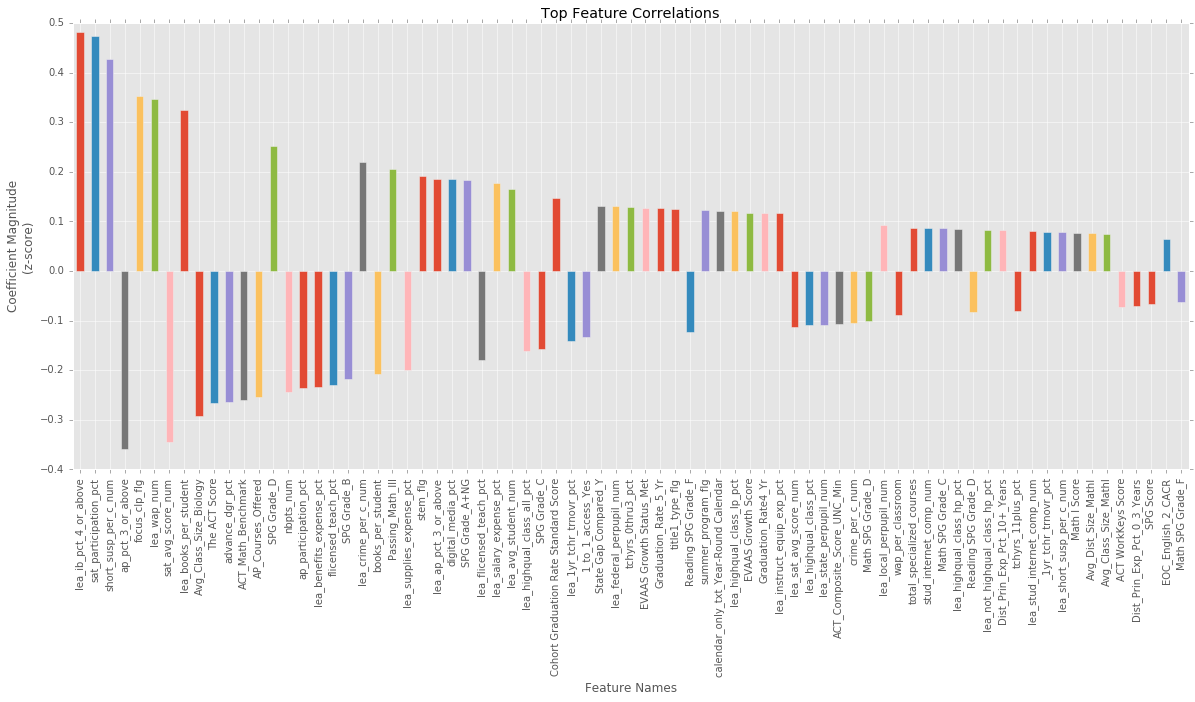

In [33]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(75)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

## Feature Importance Using Recursive Feature Elimination
**Please see the following documentation for this section**
* http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
* http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
* http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV
* https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models

In [48]:
#Convert Y to the top performing binary response 
Y = Y_MinorityPct >= 80

In [57]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

#Create a regression estimator with best parameters for cross validation
classifierEst = LogisticRegression(C=10, class_weight='none', dual=False, fit_intercept=True,
                                  intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
                                  penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
                                  verbose=0, warm_start=False)

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
rfecv.fit(X_highSchools, Y)

RFECV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
   estimator=LogisticRegression(C=10, class_weight='none', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

Optimal number of features : 101


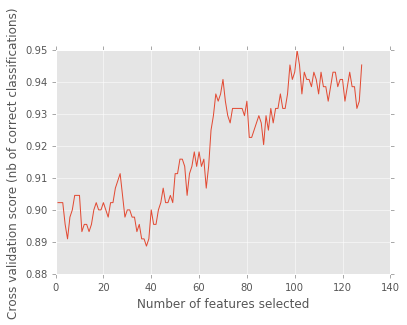

In [58]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

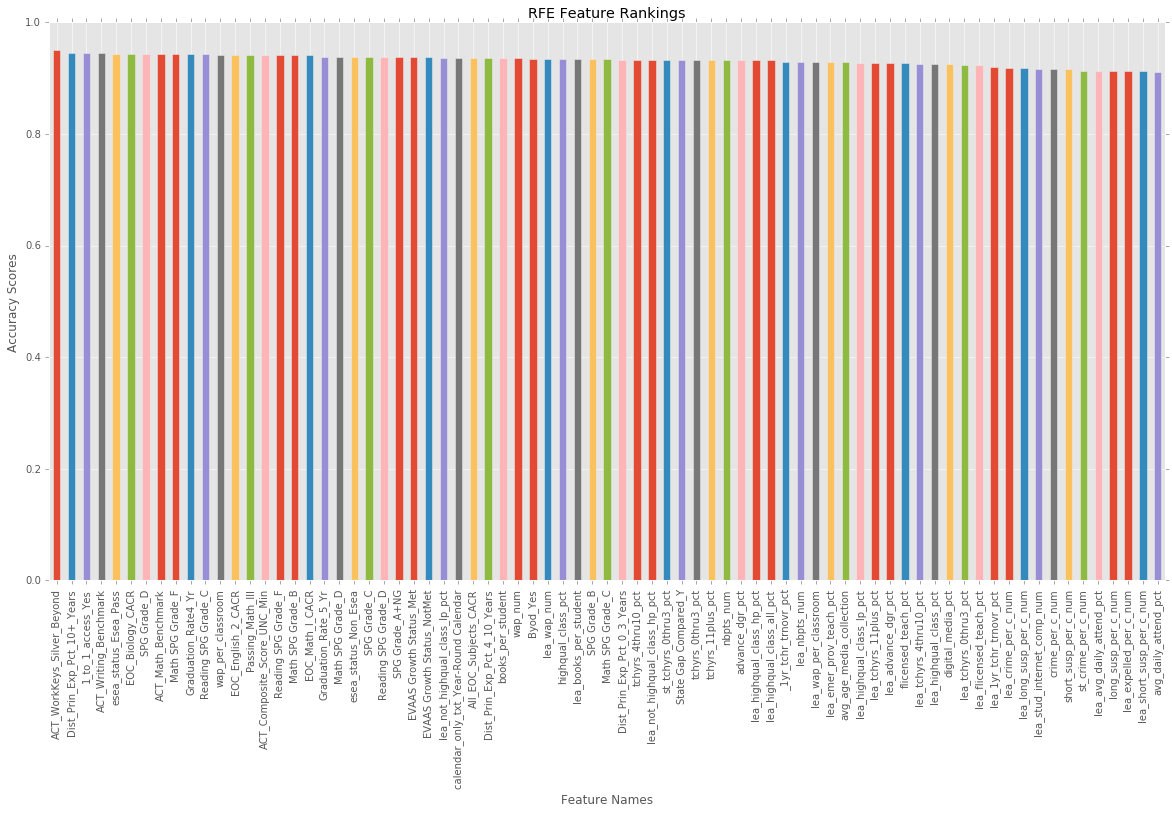

In [64]:
#Plot the RFE Rankings
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':X_highSchools.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )

top75features = rfe_ft_imp_df.head(75)

weights = pd.Series(top75features['weights'].values,index=top75features['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,10))

ax.set_title("RFE Feature Rankings")
ax.set_ylabel("Accuracy Scores")
ax.set_xlabel("Feature Names")
plt.show()

In [65]:
X_highSchools.columns[rfecv.support_]

Index([u'title1_type_flg', u'clp_ind_flg', u'focus_clp_flg',
       u'summer_program_flg', u'lea_avg_student_num', u'st_avg_student_num',
       u'Grad_project_status', u'stem_flg', u'Avg_Class_Size_Biology',
       u'Avg_Class_Size_EnglishII',
       ...
       u'SPG Grade_D', u'Reading SPG Grade_C', u'Math SPG Grade_C',
       u'Math SPG Grade_D', u'Math SPG Grade_F', u'EVAAS Growth Status_Met',
       u'EVAAS Growth Status_NotMet', u'State Gap Compared_Y', u'Byod_Yes',
       u'1_to_1_access_Yes'],
      dtype='object', length=101)

In [69]:
from sklearn.linear_model import LogisticRegression

#Select only the top features chosen by recursive feature elimination. 
X_Rfecv = rfecv.transform(X_highSchools)

#Create a regression estimator with best parameters for cross validation
classifierEst = LogisticRegression(C=10, class_weight='none', dual=False, fit_intercept=True,
                                  intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
                                  penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
                                  verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateClassifierEstimator(classifierEst, X_Rfecv, Y, cv)

The average accuracy for all cv folds is: 			 0.94545
The average precision for all cv folds is: 			 0.71333
The average recall for all cv folds is: 			 0.64032
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.886364,0.500000,0.400000
1,0.954545,0.500000,1.000000
2,0.954545,0.000000,0.000000
3,0.954545,1.000000,0.600000
4,0.931818,0.833333,0.714286
5,0.977273,0.750000,1.000000
6,0.954545,0.800000,0.800000
7,0.909091,0.750000,0.500000
8,0.977273,1.000000,0.888889
9,0.954545,1.000000,0.500000


In [74]:
#Display the top features selected
list(X_highSchools[rfecvCols].columns.values)

['title1_type_flg',
 'clp_ind_flg',
 'focus_clp_flg',
 'summer_program_flg',
 'lea_avg_student_num',
 'st_avg_student_num',
 'Grad_project_status',
 'stem_flg',
 'Avg_Class_Size_Biology',
 'Avg_Class_Size_EnglishII',
 'Avg_Dist_Size_Biology',
 'Avg_Dist_Size_MathI',
 'lea_total_expense_num',
 'lea_salary_expense_pct',
 'lea_supplies_expense_pct',
 'lea_federal_perpupil_num',
 'lea_local_perpupil_num',
 'lea_state_perpupil_num',
 'SPG Score',
 'EVAAS Growth Score',
 'Math I Score',
 'English II Score',
 'Biology Score',
 'The ACT Score',
 'ACT WorkKeys Score',
 'Math Course Rigor Score',
 'Cohort Graduation Rate Standard Score',
 'sat_avg_score_num',
 'lea_sat_avg_score_num',
 'sat_participation_pct',
 'ap_participation_pct',
 'ap_pct_3_or_above',
 'lea_ap_pct_3_or_above',
 'lea_ib_pct_4_or_above',
 'AP_Courses_Offered',
 'total_specialized_courses',
 'univ_college_courses',
 'lea_total_specialized_courses',
 'sch_percent_college_enrolled_16_mos_post_grad',
 'crime_per_c_num',
 'short_s

In [63]:
max(rfecv.grid_scores_)

0.95